## Project: Impact of Macroeconomic Factors on US Housing Prices

# Project Introduction

- In this project, we analyze how macroeconomic factors like **inflation rate**, **housing starts**, **interest rates**, **population growth**, and **unemployment rates** affect the **US Home Price Index** over time.
- We perform **Exploratory Data Analysis (EDA)**, build **simple** and **multiple linear regression models**, and apply **Ridge Regression** with **hyperparameter tuning** to improve performance.
- The goal is to **identify the most important factors** influencing **housing prices**.


# Table of Contents

- **Step 1:** Import Libraries
- **Step 2:** Load Data
- **Step 3:** Clean and Rename Columns
- **Step 4:** Data Preprocessing
- **Step 5:** Exploratory Data Analysis (EDA)
- **Step 6:** Simple Linear Regression (Using Inflation Rate)
- **Step 7:** Merge All Variables
- **Step 8:** Multiple Linear Regression
- **Step 9:** Check Multicollinearity (VIF)
- **Step 10:** Feature Selection (Based on VIF)
- **Step 11:** Ridge Regression with Hyperparameter Tuning
- **Step 12:** Model Evaluation
- **Step 13:** Bonus: Lasso Regression
- **Step 14:** Conclusion and Future Work


# Step 1: Import Libraries

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Step 2: Load Data

In [2]:
data_path = "data"
files = {
    "dependent": "dependent_variable.csv",
    "housing": "housing_starts.csv",
    "inflation": "inflation_rate.csv",
    "interest": "interest_rate.csv",
    "population": "population_growth.csv",
    "unemployment": "unemployment_rate.csv"
}

dependent_df = pd.read_csv(os.path.join(data_path, files["dependent"]), parse_dates=["observation_date"])
housing_starts_df = pd.read_csv(os.path.join(data_path, files["housing"]), parse_dates=["observation_date"])
inflation_df = pd.read_csv(os.path.join(data_path, files["inflation"]), parse_dates=["observation_date"])
interest_df = pd.read_csv(os.path.join(data_path, files["interest"]), parse_dates=["observation_date"])
population_df = pd.read_csv(os.path.join(data_path, files["population"]), parse_dates=["observation_date"])
unemployment_df = pd.read_csv(os.path.join(data_path, files["unemployment"]), parse_dates=["observation_date"])


# Step 3: Clean and Rename Columns

In [20]:
rename_map = {
    "dependent_df": {"observation_date": "DATE", "CSUSHPISA": "Home_Price_Index"},
    "housing_starts_df": {"observation_date": "DATE", "HOUST": "Housing_Starts"},
    "inflation_df": {"observation_date": "DATE", "CPIAUCSL": "Inflation_Rate"},
    "interest_df": {"observation_date": "DATE", "FEDFUNDS": "Interest_Rate"},
    "population_df": {"observation_date": "DATE", "POP": "Population_Growth"},
    "unemployment_df": {"observation_date": "DATE", "UNRATE": "Unemployment_Rate"}
}

dependent_df.rename(columns=rename_map["dependent_df"], inplace=True)
housing_starts_df.rename(columns=rename_map["housing_starts_df"], inplace=True)
inflation_df.rename(columns=rename_map["inflation_df"], inplace=True)
interest_df.rename(columns=rename_map["interest_df"], inplace=True)
population_df.rename(columns=rename_map["population_df"], inplace=True)
unemployment_df.rename(columns=rename_map["unemployment_df"], inplace=True)


# Step 4: Data Preprocessing

In [ ]:
# Align Inflation dataset with Home Price Index dates
inflation_df = inflation_df[inflation_df["DATE"] >= dependent_df["DATE"].min()]
merged_df = pd.merge(dependent_df, inflation_df, on="DATE", how="inner")


# Step 5: Exploratory Data Analysis (EDA)

## Time Trends


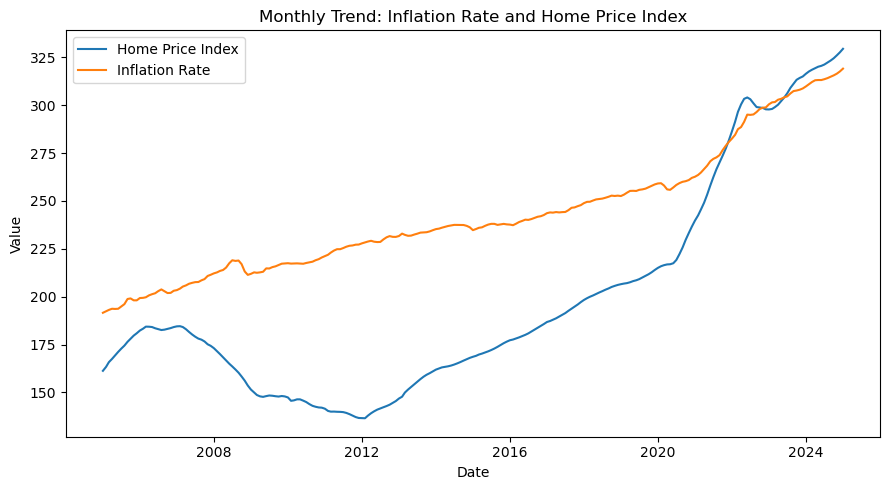

In [23]:
plt.figure(figsize=(9,5))
plt.plot(merged_df["DATE"], merged_df["Home_Price_Index"], label="Home Price Index")
plt.plot(merged_df["DATE"], merged_df["Inflation_Rate"], label="Inflation Rate")
plt.title("Monthly Trend: Inflation Rate and Home Price Index")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

## Scatter Plot

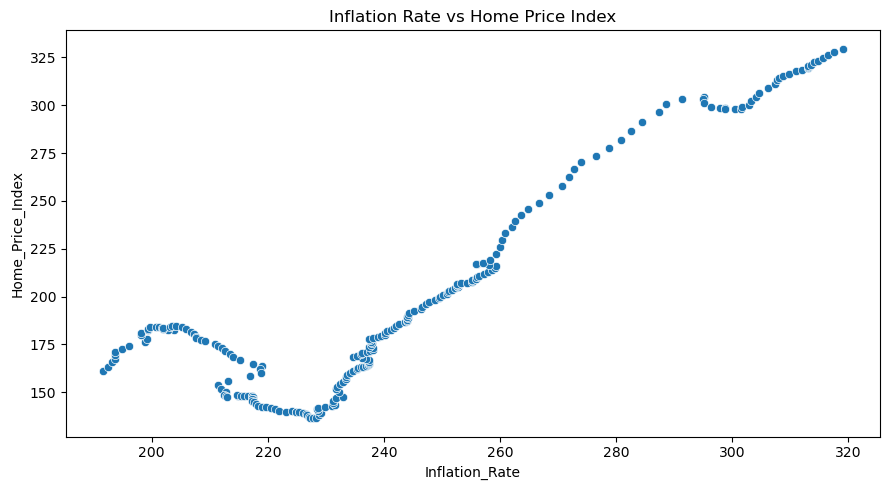

In [24]:
plt.figure(figsize=(9,5))
sns.scatterplot(x="Inflation_Rate", y="Home_Price_Index", data=merged_df)
plt.title("Inflation Rate vs Home Price Index")
plt.tight_layout()
plt.show()

## Correlation heatmap

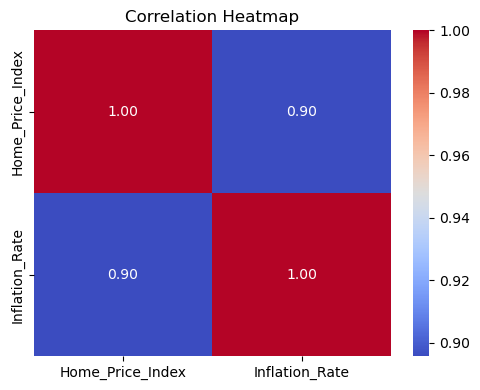

In [26]:

plt.figure(figsize=(5,4))
sns.heatmap(merged_df[["Home_Price_Index", "Inflation_Rate"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# Step 6: Simple Linear Regression (Inflation Rate)

In [29]:
X = merged_df[["Inflation_Rate"]]
y = merged_df["Home_Price_Index"]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficient: {model.coef_[0]:.2f}")
print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.2f}")
print(f"R² Score: {r2_score(y, y_pred):.2f}")


Intercept: -171.92
Coefficient: 1.53
Mean Squared Error: 608.15
R² Score: 0.80


## Regression Line Plot

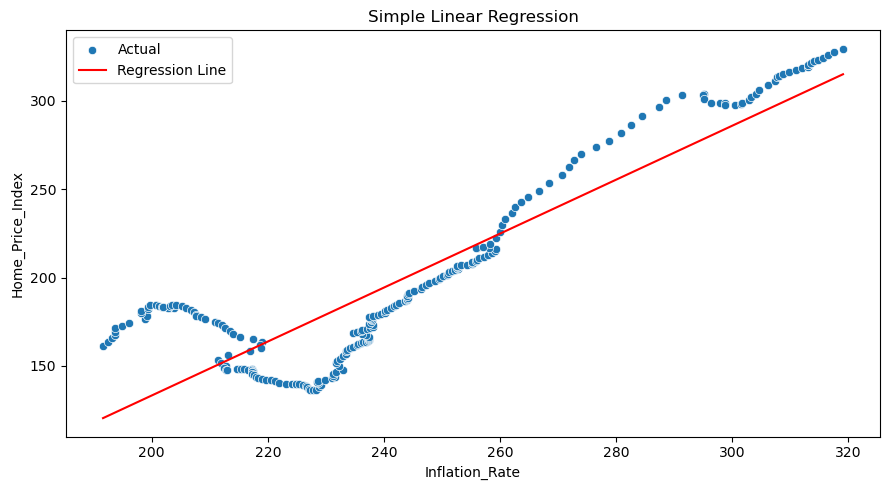

In [30]:
plt.figure(figsize=(9,5))
sns.scatterplot(x="Inflation_Rate", y="Home_Price_Index", data=merged_df, label="Actual")
plt.plot(X, y_pred, color="red", label="Regression Line")
plt.title("Simple Linear Regression")
plt.legend()
plt.tight_layout()
plt.show()


# Step 7: Merge All Variables

In [31]:
merged_df = merged_df.merge(housing_starts_df, on="DATE", how="inner")\
                     .merge(interest_df, on="DATE", how="inner")\
                     .merge(population_df, on="DATE", how="inner")\
                     .merge(unemployment_df, on="DATE", how="inner")


# Step 8: Multiple Linear Regression

In [34]:

features = ["Inflation_Rate", "Housing_Starts", "Interest_Rate", "Population_Growth", "Unemployment_Rate"]
X = merged_df[features]
y = merged_df["Home_Price_Index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Multiple Linear Regression R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})
print(coef_df)


Multiple Linear Regression R²: 0.9675948821276186
MSE: 111.06411981446145
             Feature  Coefficient
0     Inflation_Rate     2.016849
1     Housing_Starts     0.039860
2      Interest_Rate     3.250156
3  Population_Growth    -0.001601
4  Unemployment_Rate     0.922272


# Step 9: Check Multicollinearity (VIF)

In [35]:
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


             Feature         VIF
0     Inflation_Rate  159.547353
1     Housing_Starts   18.703763
2      Interest_Rate    2.782092
3  Population_Growth  288.805500
4  Unemployment_Rate   18.434793


# Step 10: Feature Selection (Based on VIF)

In [36]:
selected_features = ["Housing_Starts", "Interest_Rate", "Unemployment_Rate"]
X = merged_df[selected_features]
y = merged_df["Home_Price_Index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Reduced Model R²:", r2_score(y_test, y_pred))
print("Reduced Model MSE:", mean_squared_error(y_test, y_pred))



Reduced Model R²: 0.2503824035024831
Reduced Model MSE: 2569.212026332014


# Step 11: Ridge Regression with Hyperparameter Tuning

In [37]:
X = merged_df[features]
y = merged_df["Home_Price_Index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Ridge()
param_grid = {"alpha": [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

print("Best Alpha (Ridge):", grid_search.best_params_['alpha'])
print("Ridge Regression R²:", r2_score(y_test, y_pred))
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred))


Best Alpha (Ridge): 0.01
Ridge Regression R²: 0.9675947510592929
Ridge Regression MSE: 111.06456903326344


## Plot Actual vs Predicted

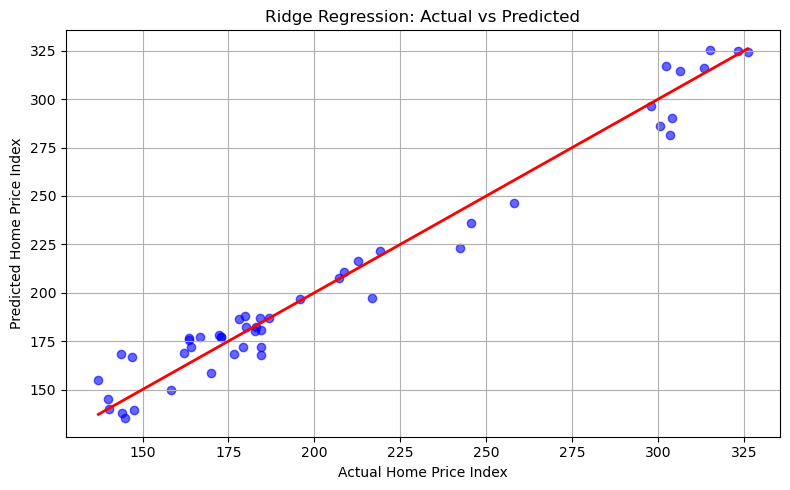

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.xlabel("Actual Home Price Index")
plt.ylabel("Predicted Home Price Index")
plt.title("Ridge Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 12: Model Evaluation

## Cross Validation and Adjusted R²

In [39]:

ridge_cv_score = cross_val_score(ridge, X, y, cv=5, scoring='r2')
print("Cross-validation R² scores:", ridge_cv_score)
print("Average Cross-validation R²:", ridge_cv_score.mean())

n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)


Cross-validation R² scores: [-2.66569001e+01 -1.28909593e+01 -2.98515815e-01  2.31452582e-02
 -5.45895910e+00]
Average Cross-validation R²: -9.056437807974788
Adjusted R²: 0.9638266988568851


# Step 13: Bonus - Lasso Regression

In [40]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

print("Lasso Regression R²:", r2_score(y_test, lasso_pred))
print("Lasso Regression MSE:", mean_squared_error(y_test, lasso_pred))


Lasso Regression R²: 0.9674316129959231
Lasso Regression MSE: 111.62370248520048


# Conclusion and Future Scope

- **Inflation Rate**, **Housing Starts**, **Interest Rate**, and **Unemployment Rate** have a significant impact on the **Home Price Index**.
- **Simple Linear Regression** using only Inflation Rate provided basic insights but was limited.
- **Multiple Linear Regression** with feature selection (via **VIF**) improved model performance.
- **Ridge Regression** with **Hyperparameter Tuning** further enhanced model generalization by reducing overfitting.

## Future Work
- Advanced models like **Random Forest Regression** or **XGBoost** could be explored to capture **non-linear relationships** and further improve predictive performance.
- Additionally, incorporating more macroeconomic factors like **GDP growth**, **rental yields**, and **government policies** could provide deeper and richer insights.
